In [2]:
import pandas as pd 
import math
import numpy as np
import matplotlib.pyplot as plt

# load dataframes from CSV files 
from data.load_csv import load_cleaned_data
from data.load_csv import date as data_date, div_name

tournament_df, bout_df, fencer_bio_df, fencer_rankings_df = load_cleaned_data()

In [4]:
tournament_df.head()

,competition_ID,season,name,category,country,start_date,end_date,weapon,gender,timezone,url,unique_ID,missing_results_flag
0,121,2021,Grand Prix,Senior,QATAR,2021-03-26,2021-03-28,Foil,Womens,Asia/Qatar,https://fie.org/competitions/2021/121,2021-121,NaN
1,41,2017,Tournoi international,Junior,GERMANY,2016-10-28,2016-10-28,Foil,Womens,Europe/Berlin,https://fie.org/competitions/2017/41,2017-41,NaN
2,800,2015,Championnats Panaméricains,Senior,CHILE,2015-04-17,2015-04-26,Foil,Womens,America/Santiago,https://fie.org/competitions/2015/800,2015-800,NaN
3,243,2019,Championnats du Monde,Senior,HUNGARY,2019-07-16,2019-07-19,Foil,Womens,Europe/Budapest,https://fie.org/competitions/2019/243,2019-243,NaN
4,237,2016,Championnats du monde juniors-cadets,Cadet,FRANCE,2016-04-01,2016-04-01,Foil,Womens,Europe/Paris,https://fie.org/competitions/2016/237,2016-237,NaN


In [5]:
bout_df.head()

,fencer_ID,opp_ID,fencer_age,opp_age,fencer_score,opp_score,winner_ID,fencer_curr_pts,opp_curr_pts,tournament_ID,pool_ID,upset,date
0,36796,19574,23,28,5,1,36796,12.5,7.50,2021-121,1,False,2021-03-26
1,36796,42147,23,19,5,2,36796,12.5,0.75,2021-121,1,False,2021-03-26
2,36796,49116,23,21,5,2,36796,12.5,22.25,2021-121,1,True,2021-03-26
3,36796,39631,23,18,5,4,36796,12.5,23.00,2021-121,1,True,2021-03-26
4,36796,23447,23,27,4,5,23447,12.5,79.00,2021-121,1,False,2021-03-26


In [6]:
fencer_bio_df.head()

,id,name,country_code,country,hand,age,url,date_accessed
0,28761,DVORKIN Mary,ISR,ISRAEL,Left,24,https://fie.org/athletes/28761,2021-05-13 21:42:17
1,43803,SHI Yue,CHN,CHINA,Right,22,https://fie.org/athletes/43803,2021-05-13 21:35:13
2,46080,TANG Nga Hei,MAC,"MACAO, CHINA",Right,20,https://fie.org/athletes/46080,2021-05-13 21:46:21
3,46481,WONAME Kelsey Victoria Afriyie,GHA,GHANA,Right,17,https://fie.org/athletes/46481,2021-05-13 21:48:14
4,47075,BRECHERET Carolina,BRA,BRAZIL,Right,16,https://fie.org/athletes/47075,2021-05-13 21:50:07


In [8]:
fencer_rankings_df.head(10)

rank  points
id   weapon category season                 
164  Foil   Veterans 2016/2017    78     0.0
                     2016/2017    78     0.0
                     2017/2018    37     0.0
                     2017/2018    37     0.0
234  Foil   Senior   2007/2008    52    56.0
                     2008/2009    80    22.0
1276 Sabre  Senior   2005/2006    72    16.0
                     2005/2006    72    16.0
                     2006/2007   306     0.0
                     2006/2007   306     0.0

## Motivation

It is "common wisdom" that left-handed fencer's have an advantage over their more common right-handed counterparts. The prevailing wisdom is that left-handed fencers are more rare, and thus athletes have less experience against them and perform worse when faced with a left-handed opponent. 

The goal of this analysis is examine numerical properties of left handed fencers and determine the extent of this effect. 

First, what is the proportion of left handed fencers?

In [16]:
left_count = fencer_bio_df[fencer_bio_df['hand'] == 'Left'].shape[0]
right_count = fencer_bio_df[fencer_bio_df['hand'] == 'Right'].shape[0]
left_prop = left_count / (left_count + right_count)
print("Percentage of Left Handed Fencers: {:.1f}%".format(100*left_prop))

Percentage of Left Handed Fencers: 17.0%


If there were no handedness effect, we would expect fencers to win the same proportion of bouts against lefties and righties. 

In [21]:
# compute win proportions per fencer by handedness of opponent
bout_winners = bout_df[['fencer_ID','opp_ID','winner_ID']]
bout_winners.head()


,fencer_ID,opp_ID,winner_ID
0,36796,19574,36796
1,36796,42147,36796
2,36796,49116,36796
3,36796,39631,36796
4,36796,23447,23447


In [28]:
bouts_by_opp_hand = bout_winners.merge(fencer_bio_df[['id','hand']], how="inner", left_on='opp_ID', right_on='id')
bouts_by_opp_hand = bouts_by_opp_hand[['fencer_ID','opp_ID','winner_ID','hand']].rename(columns={'hand':'opp_hand'})
bouts_by_opp_hand.head()

,fencer_ID,opp_ID,winner_ID,opp_hand
0,36796,19574,36796,Left
1,30222,19574,19574,Left
2,26961,19574,19574,Left
3,38052,19574,38052,Left
4,4405,19574,4405,Left


In [30]:
switched_bouts = bouts_by_opp_hand.rename(columns={'fencer_ID':'opp_ID','opp_ID':'fencer_ID'})
switched_bouts.head()

,opp_ID,fencer_ID,winner_ID,opp_hand
0,36796,19574,36796,Left
1,30222,19574,19574,Left
2,26961,19574,19574,Left
3,38052,19574,38052,Left
4,4405,19574,4405,Left


In [33]:
switched_bouts.shape

(49131, 4)

In [35]:
double_bouts = pd.concat([bouts_by_opp_hand,switched_bouts])
double_bouts.head()

,fencer_ID,opp_ID,winner_ID,opp_hand
0,36796,19574,36796,Left
1,30222,19574,19574,Left
2,26961,19574,19574,Left
3,38052,19574,38052,Left
4,4405,19574,4405,Left


In [47]:
double_bouts[double_bouts['winner_ID'] == 38052]

,fencer_ID,opp_ID,winner_ID,opp_hand
3,38052,19574,38052,Left
3,19574,38052,38052,Left


In [49]:
bouts_by_opp_hand[bouts_by_opp_hand['winner_ID'] == 38052]

,fencer_ID,opp_ID,winner_ID,opp_hand
3,38052,19574,38052,Left


In [59]:
double_bouts['fencer_won'] = double_bouts['fencer_ID'] == double_bouts['winner_ID']


In [60]:
double_bouts

,fencer_ID,opp_ID,winner_ID,opp_hand,fencer_won
0,36796,19574,36796,Left,True
1,30222,19574,19574,Left,False
2,26961,19574,19574,Left,False
3,38052,19574,38052,Left,True
4,4405,19574,4405,Left,True
...,...,...,...,...,...
49126,14515,12156,12156,Right,False
49127,14515,24381,24381,Right,False
49128,15013,35097,35097,Right,False
49129,15013,29054,29054,Right,False


In [68]:
win_prop_by_opp_hand = double_bouts.drop(columns=['opp_ID', 'winner_ID']).groupby(['fencer_ID','opp_hand']).mean().reset_index()
win_prop_by_opp_hand.head()

,fencer_ID,opp_hand,fencer_won
0,164,Left,0.400000
1,164,Right,0.272727
2,234,Left,1.000000
3,234,Right,1.000000
4,1006,Right,0.000000


In [71]:
import seaborn as sns

In [73]:
win_prop_by_opp_hand[['opp_hand','fencer_won']].groupby('opp_hand').mean()

,fencer_won
opp_hand,
Left,0.335328
Right,0.371366


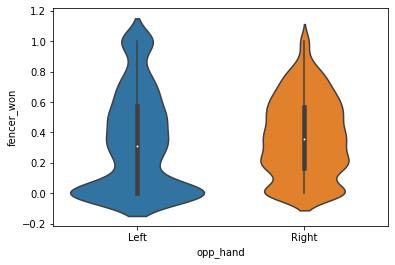

In [81]:
ax = sns.violinplot(x="opp_hand",y="fencer_won", data=win_prop_by_opp_hand)

There is a large portion of fencers for whom the win percentage against lefties is very low. But there is also a smaller group with very high performance against left handed fencers 


Per fencer, how do these quanities differ? 

In [87]:
fencer_wins_by_opp_hand = win_prop_by_opp_hand.pivot(index='fencer_ID',columns='opp_hand',values='fencer_won').dropna()
fencer_wins_by_opp_hand.head()

opp_hand,Left,Right
fencer_ID,,
164,0.400000,0.272727
234,1.000000,1.000000
1276,0.000000,0.000000
1424,0.333333,0.555556
1455,0.472727,0.582090


In [95]:
fencer_wins_by_opp_hand['win_diff'] = fencer_wins_by_opp_hand['Right'] - fencer_wins_by_opp_hand['Left'] 
fencer_wins_by_opp_hand.head()

opp_hand,Left,Right,win_diff
fencer_ID,,,
164,0.400000,0.272727,-0.127273
234,1.000000,1.000000,0.000000
1276,0.000000,0.000000,0.000000
1424,0.333333,0.555556,0.222222
1455,0.472727,0.582090,0.109362


In [91]:
fencer_wins_by_opp_hand['win_diff'].mean()

0.06827562469533635

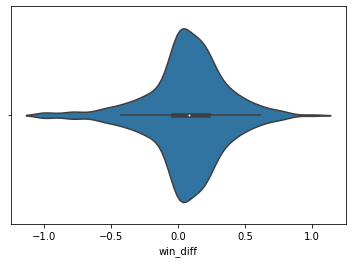

In [90]:
ax = sns.violinplot(x="win_diff", data=fencer_wins_by_opp_hand)

Now it might be that better fencers learn how to combat left handed fencers over time, diminishing the gains. It also might be that left handed fencers fair better against fellow lefties. 

In [100]:
wins_by_fencer_hand = fencer_wins_by_opp_hand.reset_index().merge(fencer_bio_df[['id','hand']],how="inner",  left_on='fencer_ID', right_on='id')
wins_by_fencer_hand.head()

,fencer_ID,Left,Right,win_diff,id,hand
0,164,0.400000,0.272727,-0.127273,164,Right
1,234,1.000000,1.000000,0.000000,234,Left
2,1276,0.000000,0.000000,0.000000,1276,Right
3,1424,0.333333,0.555556,0.222222,1424,Right
4,1455,0.472727,0.582090,0.109362,1455,Left


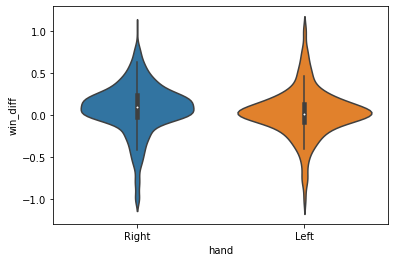

In [101]:
ax = sns.violinplot(x="hand",y="win_diff", data=wins_by_fencer_hand)

The left handed fencers do seem to have a slightly lower win percentage difference against righties vs lefties, meaning they tend to perform slightly better than righties against left handed fencers. 

In [106]:
overall_win_percents = double_bouts[['fencer_ID','fencer_won']].groupby('fencer_ID').mean().rename(columns={'fencer_won':'win_percent'})
overall_win_percents.head()

,win_percent
fencer_ID,
164,0.312500
234,1.000000
1006,0.000000
1276,0.000000
1412,0.333333


In [116]:
combined_wins_data_by_fencer = fencer_wins_by_opp_hand.merge(overall_win_percents, 
                                                             left_index=True, right_index=True)
combined_wins_data_by_fencer = combined_wins_data_by_fencer.merge(fencer_bio_df[['id','hand']], 
                                                             left_index=True, right_on='id')
combined_wins_data_by_fencer.head()

,Left,Right,win_diff,win_percent,id,hand
640,0.400000,0.272727,-0.127273,0.312500,164,Right
1979,1.000000,1.000000,0.000000,1.000000,234,Left
1415,0.000000,0.000000,0.000000,0.000000,1276,Right
724,0.333333,0.555556,0.222222,0.500000,1424,Right
116,0.472727,0.582090,0.109362,0.514124,1455,Left


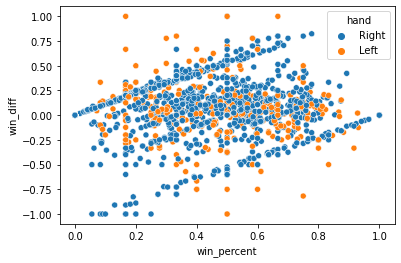

In [118]:
sns.scatterplot(data=combined_wins_data_by_fencer, x='win_percent',y='win_diff', hue='hand');

What is up with the two lines? 